## Credit Card Fraud Detection

**Use Case:** The credit-card company has released an anonymized list of time-recorded European card transactions to detect fraudulent credit-card transactions for two days in September 2013. The data contains a highly imbalanced (small) percentage of transactions that are fraudulent. The goal is to train the computer to detect fraudulent transactions. To assess the performance of various machine/deep-learning algorithms, we carry out and evaluate two popular models that are often used to cope with imbalanced datasets. They are (1) *autoencoder neural networks*, (2) *support vector machines* and (3) *decision trees*. 

**Data Source:** Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud


### Data inspection and ETL

#### The CSV file creditcard.csv is downloaded and stored in IBM Cloud Object Storage. Data from it are then extracted and converted to Spark dataframe with appropriate credentials.

In [ ]:
# The code was removed by Watson Studio for sharing.

In [1]:
import ibmos2spark

configuration_name = 'os_3253229b087f481987a8b59b2f9ce876_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession

spark=SparkSession.builder.getOrCreate()
df_credit = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('creditcard.csv', 'ibmadvanceddatasciencecapstone-donotdelete-pr-iivs2mtioqigul'))
df_credit.take(5)

[Row(Time=u'0', V1=u'-1.3598071336738', V2=u'-0.0727811733098497', V3=u'2.53634673796914', V4=u'1.37815522427443', V5=u'-0.338320769942518', V6=u'0.462387777762292', V7=u'0.239598554061257', V8=u'0.0986979012610507', V9=u'0.363786969611213', V10=u'0.0907941719789316', V11=u'-0.551599533260813', V12=u'-0.617800855762348', V13=u'-0.991389847235408', V14=u'-0.311169353699879', V15=u'1.46817697209427', V16=u'-0.470400525259478', V17=u'0.207971241929242', V18=u'0.0257905801985591', V19=u'0.403992960255733', V20=u'0.251412098239705', V21=u'-0.018306777944153', V22=u'0.277837575558899', V23=u'-0.110473910188767', V24=u'0.0669280749146731', V25=u'0.128539358273528', V26=u'-0.189114843888824', V27=u'0.133558376740387', V28=u'-0.0210530534538215', Amount=u'149.62', Class=u'0'),
 Row(Time=u'0', V1=u'1.19185711131486', V2=u'0.26615071205963', V3=u'0.16648011335321', V4=u'0.448154078460911', V5=u'0.0600176492822243', V6=u'-0.0823608088155687', V7=u'-0.0788029833323113', V8=u'0.0851016549148104', V9

#### Data properties are checked.

In [ ]:
num_smp = df_credit.count() # Number of samples
num_feat = len(df_credit.columns) # Number of features
print(num_smp,num_feat)

In [ ]:
df_credit.printSchema()

#### Cast the entire dataframe to float format. Note that PCA is already performed on the original confidential dataset to form this current public dataset to protect the identities of the card users.

In [ ]:
from pyspark.sql.functions import col

df_credit=df_credit.select(*(col(c).cast("float").alias(c) for c in df_credit.columns))
df_credit.printSchema()

#### We now upload the preprocessed dataframe to the persistent Spark storage format for later use.

In [ ]:
from pyspark.sql import SparkSession

spark=SparkSession.builder.getOrCreate()
df_credit=df_credit.repartition(1)
df_credit.write.mode('overwrite').parquet(cos.url('credit.parquet','ibmadvanceddatasciencecapstone-donotdelete-pr-iivs2mtioqigul'))

### Load data from Object Storage

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190316140701-0004
KERNEL_ID = e2e9d154-9fbf-4856-909c-d5887f63f8a8


In [2]:
import ibmos2spark

configuration_name = 'os_3253229b087f481987a8b59b2f9ce876_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()

df_credit=spark.read.parquet(cos.url('credit.parquet','ibmadvanceddatasciencecapstone-donotdelete-pr-iivs2mtioqigul'))

### Load all packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
import itertools
import json

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.feature import VectorAssembler, Normalizer, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql import DataFrame

from functools import reduce

Using TensorFlow backend.


### Data visualization

In [4]:
df=df_credit.toPandas()

In [5]:
df_legal=df.loc[df['Class'] == 0]
df_fraud=df.loc[df['Class'] == 1]

df_legal=df_legal.values
df_fraud=df_fraud.values

df_legal.shape

(284315, 31)

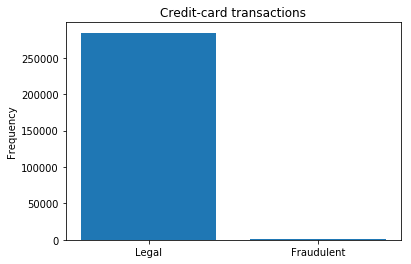

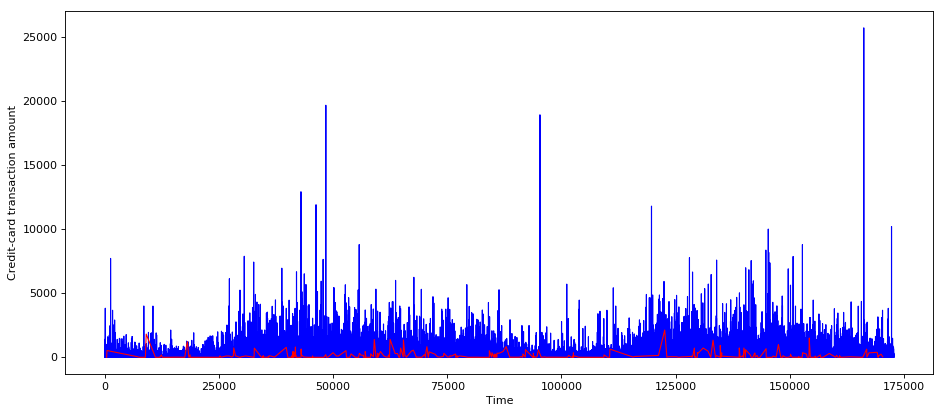

In [6]:
size_l = len(df_legal)
size_f = len(df_fraud)

plt.bar([0,1], [size_l,size_f], align='center', alpha=1)
plt.xticks([0,1],['Legal','Fraudulent'])
plt.ylabel('Frequency')
plt.title('Credit-card transactions')
 
plt.show()

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(df_legal[:,0], df_legal[:,29], '-', color='blue', animated = True, linewidth=1)
ax.plot(df_fraud[:,0], df_fraud[:,29], '-', color='red', animated = True, linewidth=1)
plt.ylabel('Credit-card transaction amount')
plt.xlabel('Time')
plt.show()


#### As expected, the dataset is highly imbalanced with a very low percentage of fraudulent transactions. The above time series shows that, apart from the user characteristics V1 to V28, small transaction amounts are also signatures of fraudulent credit-card activities.

### (1) We first train the machine to detect fraudulent transactions with Autoencoders using Keras

### Preprocess the transactions data and group the legal transactions for training

In [7]:
df_prep=df.drop('Time',axis=1)                           # Remove the 'Time' column.
df_class=df_prep['Class']                                # Extract class labels store it.
header = list(df_prep)
df_prep=StandardScaler().fit(df_prep).transform(df_prep) # Perform standard feature scaling
df_prep=pd.DataFrame(data=df_prep,columns=header)        # Reinstate column headers
df_prep['Class']=df_class                                # Reinstate correct class labels

X_train, X_rest = train_test_split(df_prep, test_size=0.4)  # Split data to 60% training, 20% validation and 20% test
X_val, X_test = train_test_split(X_rest, test_size=0.5)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop('Class', axis=1)
y_val = X_val['Class']
X_val = X_val.drop('Class', axis=1)
y_test = X_test['Class']
X_test = X_test.drop('Class', axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

print(X_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(170566, 29)
(56961, 29)
(56961,)
(56962, 29)
(56962,)


In [8]:
df_prep.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0.0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0.0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0.0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0.0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0.0


### Define the autoencoder model

In [75]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))

# encoder = Dense(40, activation="tanh", 
#                 activity_regularizer=regularizers.l1(1e-10))(input_layer)
# encoder = Dense(35, activation="tanh")(encoder)
# encoder = Dense(30, activation="tanh")(encoder)
# encoder = Dense(20, activation="tanh")(encoder)
# decoder = Dense(30, activation="relu")(encoder)
# decoder = Dense(35, activation="relu")(decoder)
# decoder = Dense(40, activation="relu")(decoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

encoder = Dense(40, activation="tanh", 
                activity_regularizer=regularizers.l1(1e-10))(input_layer)
encoder = Dense(20, activation="tanh")(encoder)
decoder = Dense(20, activation="relu")(encoder)
decoder = Dense(40, activation="relu")(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', 
                    loss='mae', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model_autoenc.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

with open('model_autoenc_hist.txt', 'w') as outfile:  
    json.dump(history, outfile)

Train on 170608 samples, validate on 56961 samples
Epoch 1/100
170608/170608 [==============================] - 17s 98us/step - loss: 0.4512 - acc: 0.6088 - val_loss: 0.4154 - val_acc: 0.7055
Epoch 2/100
170608/170608 [==============================] - 16s 96us/step - loss: 0.4058 - acc: 0.7115 - val_loss: 0.4040 - val_acc: 0.7196
Epoch 3/100
170608/170608 [==============================] - 16s 96us/step - loss: 0.3960 - acc: 0.7309 - val_loss: 0.3969 - val_acc: 0.7393
Epoch 4/100
170608/170608 [==============================] - 16s 96us/step - loss: 0.3889 - acc: 0.7587 - val_loss: 0.3920 - val_acc: 0.7590
Epoch 5/100
170608/170608 [==============================] - 18s 103us/step - loss: 0.3869 - acc: 0.7608 - val_loss: 0.3891 - val_acc: 0.7623
Epoch 6/100
170608/170608 [==============================] - 16s 94us/step - loss: 0.3857 - acc: 0.7615 - val_loss: 0.3899 - val_acc: 0.7608
Epoch 7/100
170608/170608 [==============================] - 16s 96us/step - loss: 0.3849 - acc: 0.761

NameError: name 'json' is not defined

### Evaluating the autoencoder results

#### We judge that the autoencoder converges well from both the loss and accuracy learning curves.

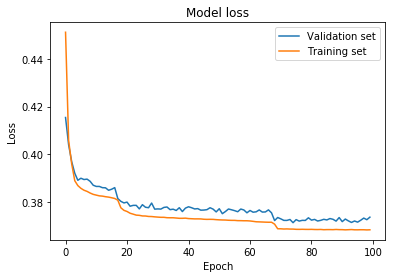

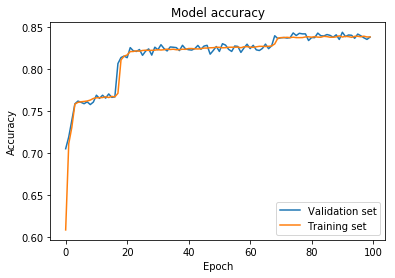

In [9]:
with open('model_autoenc_hist.txt') as json_file:  
    history_ld = json.load(json_file)
    
autoencoder_ld = load_model('model_autoenc.h5')

plt.plot(history_ld['val_loss'])
plt.plot(history_ld['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation set','Training set']);
plt.show()

plt.plot(history_ld['val_acc'])
plt.plot(history_ld['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation set','Training set']);
plt.show()

#### Since this dataset is highly imbalanced, we first investigate the confustion matrix for a fixed threshold. It turns out that while the autoencoder prediction is capable of rooting out a large portion of fraudulent transactions (high recall), it is at the same time relatively inaccurate in recognizing legal transactions (low precision).

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

Statistics for test data: accuracy,precision,recall,F1  0.987553105579 0.0913907284768 0.75 0.16292798111
Confusion matrix, without normalization
[[56184   686]
 [   23    69]]


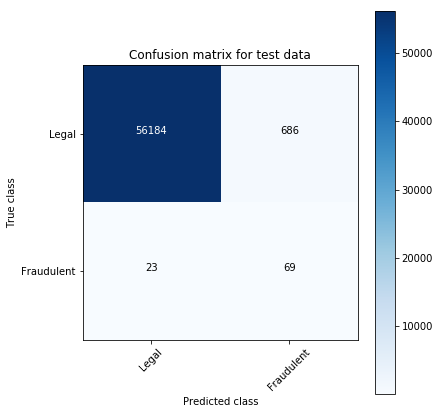

In [11]:
predictions = autoencoder_ld.predict(X_test) # Autoencoder predictions are feature values, not class labels.
mse = np.mean(np.power(X_test - predictions, 2), axis=1) # Compute reconstruction error based on mean squared-error.
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

threshold=1e-2 # Normalized to 1, this threshold is defined for MSE.

LABELS=['Legal','Fraudulent']
y_pred = [1 if e > threshold*np.max(error_df.reconstruction_error.values) else 0 for e in error_df.reconstruction_error.values] # Classify based on reconstruction error.
cm = confusion_matrix(error_df.true_class, y_pred)

accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
F1=2.*precision*recall/(precision+recall)
print("Statistics for test data: accuracy,precision,recall,F1 ",accuracy,precision,recall,F1)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=LABELS,normalize= False,  title='Confusion matrix for test data')

#### More appropriately, we should look at the precision-recall curve (https://doi.org/10.1371/journal.pone.0118432) and make sure that the area under it is large. This generally corresponds to high precision and high recall.  For our autoencoder, the area under the curve is indeed small.

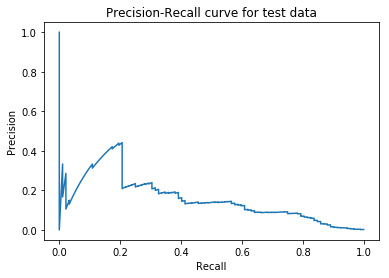

Area Under PR Curve: 0.15307208328


In [12]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision)
plt.title('Precision-Recall curve for test data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

print("Area Under PR Curve:", auc(recall,precision))

#### We therefore need a better machine-learning algorithm to increase this area.

### (2) Let us train the computer with Support Vector Machines using Sklearn 

[LibSVM]

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Statistics for test data: accuracy,precision,recall,F1  0.999321184883 0.888888888889 0.697986577181 0.781954887218
Confusion matrix, without normalization
[[85281    13]
 [   45   104]]


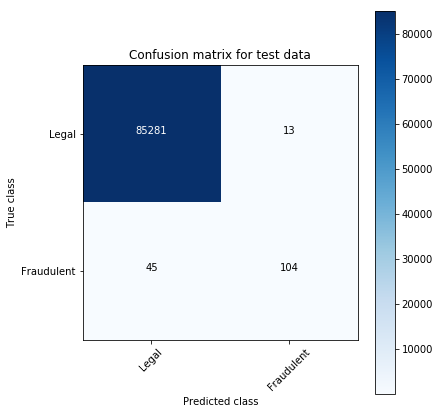

In [13]:
X_train, X_test = train_test_split(df_prep, test_size=0.3)  # Split data to 70% training and 30% test

y_train = X_train['Class']
X_train = X_train.drop('Class', axis=1)
y_test = X_test['Class']
X_test = X_test.drop('Class', axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

clf = svm.SVC(kernel='rbf',verbose=True,max_iter=200,probability=True)
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
cm = confusion_matrix(y_test, yhat)

accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
F1=2.*precision*recall/(precision+recall)
print("Statistics for test data: accuracy,precision,recall,F1 ",accuracy,precision,recall,F1)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=LABELS,normalize= False,  title='Confusion matrix for test data') # Fixed at standard probability threshold of 0.5

#### We see that this time, compared to autoencoders, SVM gives a much more optimistic prediction with relatively high precision and recall. Its precision-recall curve also possesses a larger area.

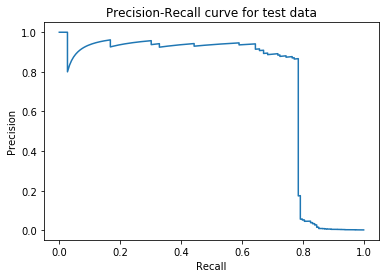

Area Under PR Curve: 0.733630978817


In [14]:
yhat_prob = clf.predict_proba(X_test)
precision, recall, th = precision_recall_curve(y_test, yhat_prob[:,1])
plt.plot(recall, precision)
plt.title('Precision-Recall curve for test data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

print("Area Under PR Curve:", auc(recall,precision))

#### We shall see that it is indeed possible to improve this result further!

### (3a) We now train the machine with Random-Forest Decision Trees with Apache Spark

In [15]:
splits=df_credit.randomSplit([0.7,0.3]) # Split data to 70% training and 30% test
df_train=splits[0]
df_test=splits[1]

In [16]:
df_train=reduce(DataFrame.drop, ['Time'], df_train)   # Drop 'Time' column from the training dataset
df_test=reduce(DataFrame.drop, ['Time'], df_test)    # Drop 'Time' column from the test dataset

print(len(df_train.columns),len(df_test.columns))

header = list(df_prep)

vectorAssembler=VectorAssembler(inputCols=header,outputCol='features')                        # Assembler feature vector
labelIndexer = StringIndexer(inputCol="Class", outputCol="indexedClass").fit(df_train)        # Index class labels

normalizer = Normalizer(inputCol='features',outputCol='features_norm',p=2.0)                  # Normalize the feature matrix

tree_classifier =RandomForestClassifier(labelCol='indexedClass',featuresCol='features_norm',numTrees=2,seed=0)    # Define a classifier

pipeline=Pipeline(stages=[vectorAssembler,labelIndexer,normalizer,tree_classifier])           # Assemble the ML pipeline

30 30


In [17]:
model =pipeline.fit(df_train)
predict_train=model.transform(df_train)
predict_test=model.transform(df_test)

### Evaluate the Random-Forest predictions first with the confusion matrix

#### We find that RF only roots out most fraudulent cases, but also recognizes almost all legal transactions from the test dataset.

Statistics for test data: accuracy,precision,recall,F1  0.999298409729 1.0 0.56204379562 0.719626168224
Confusion matrix, without normalization
[[85383     0]
 [   60    77]]


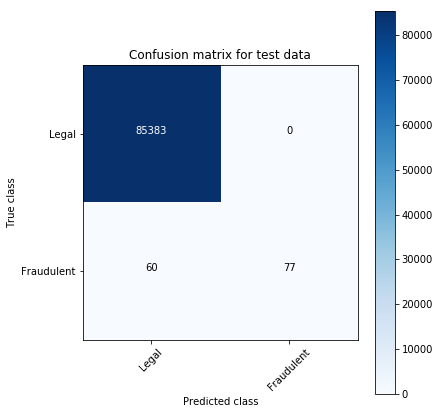

In [18]:
results = predict_test.select(['prediction', 'Class'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
F1=2.*precision*recall/(precision+recall)
print("Statistics for test data: accuracy,precision,recall,F1 ",accuracy,precision,recall,F1)

cm=cm.astype('int')
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=LABELS,normalize= False,  title='Confusion matrix for test data') # Fixed at standard probability threshold of 0.5

#### As a matter of fact, we obtain a rather large area for the precision-recall curve.

In [19]:
y_proba=predict_test.select("probability").collect()
y_proba=np.asarray([x[0] for x in y_proba])
y_test=predict_test.select("Class").collect()
y_test=np.asarray([x[0] for x in y_test])

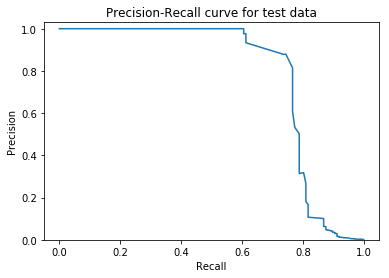

Area under PR curve: 0.7778907108068087


In [20]:
precision, recall, th = precision_recall_curve(y_test, y_proba[:,1])
plt.plot(recall, precision)
plt.title('Precision-Recall curve for test data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1.03])
plt.show()

eval = BinaryClassificationEvaluator().setMetricName('areaUnderPR').setLabelCol('Class').setRawPredictionCol("rawPrediction")
print('Area under PR curve:',eval.evaluate(predict_test))

#### We therefore conclude that Decision Trees are the best alternative for detecting anomalous credit-card frauduluent activities.

### (3b) Slight enhancement can be provided by Gradient Boosted Trees.

In [21]:
vectorAssembler=VectorAssembler(inputCols=header,outputCol='features')
labelIndexer = StringIndexer(inputCol="Class", outputCol="indexedClass").fit(df_train)

normalizer = Normalizer(inputCol='features',outputCol='features_norm',p=2.0)

tree_classifier =GBTClassifier(labelCol='indexedClass',featuresCol='features_norm',maxIter=1)

pipeline=Pipeline(stages=[vectorAssembler,labelIndexer,normalizer,tree_classifier])

model =pipeline.fit(df_train)
predict_train=model.transform(df_train)
predict_test=model.transform(df_test)

Statistics for test data: accuracy,precision,recall,F1 0.999847988775 1.0 0.905109489051 0.950191570881
Confusion matrix, without normalization
[[85383     0]
 [   13   124]]


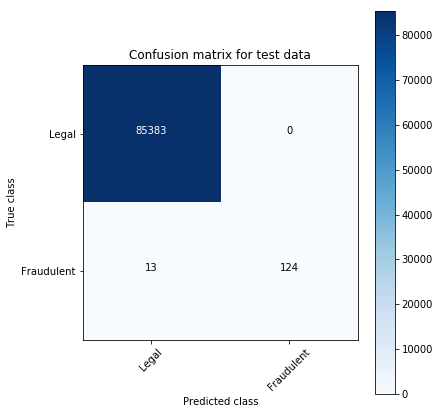

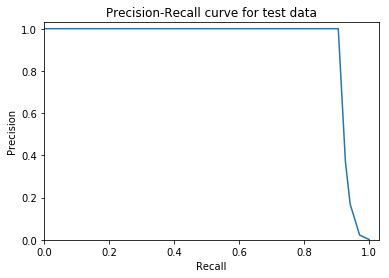

Area under PR curve: 0.9272094561210034


In [22]:
results = predict_test.select(['prediction', 'Class'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[1][1])/(cm[1][1]+cm[0][1])
recall=(cm[1][1])/(cm[1][1]+cm[1][0])
F1=2.*precision*recall/(precision+recall)
print("Statistics for test data: accuracy,precision,recall,F1",accuracy,precision,recall,F1)

cm=cm.astype('int')
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=LABELS,normalize= False,  title='Confusion matrix for test data') # Fixed at standard probability threshold of 0.5
plt.show()

y_proba=predict_test.select("probability").collect()
y_proba=np.asarray([x[0] for x in y_proba])
y_test=predict_test.select("Class").collect()
y_test=np.asarray([x[0] for x in y_test])

precision, recall, th = precision_recall_curve(y_test, y_proba[:,1])
plt.plot(recall, precision)
plt.title('Precision-Recall curve for test data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1.03])
plt.xlim([0,1.03])
plt.show()

eval = BinaryClassificationEvaluator().setMetricName('areaUnderPR').setLabelCol('Class').setRawPredictionCol("rawPrediction")
print('Area under PR curve:',eval.evaluate(predict_test))

#### In effect, we have reproduced the general reported observation in the proceedings paper http://www.iaeng.org/publication/IMECS2011/IMECS2011_pp442-447.pdf ---- Decision-Tree classifiers outperform SVMs in credit-card fraud detection.

### Conclusion

We have carried out two different classes of machine/deep-learning algorithms to train the computer for credit-card fraud detection, namely autoencoder neural networks and decision-tree classifiers. It turns out that the autoencoder neural networks quite often misclassifies legal transactions as fraudulent on test/validation data even though they manage to root out a large portion of fraudulent transactions. On the other hand, decision-tree algorithms are more reliable in both recognizing legal transactions and rooting out fraudulent ones. Our evaluation shows that Gradient Boosted Trees give the most promising results.